# Libraries installation

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install kaggle --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
import itertools
from nltk.tokenize import RegexpTokenizer
from google.colab import drive 
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

!pip install pyspark
import pyspark
from pyspark.sql import SparkSession

!pip install graphframes
from graphframes import GraphFrame

from pyspark.sql import Row

import networkx as nx

from numpy.lib.function_base import vectorize

from collections import OrderedDict

In [ ]:
os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages graphframes:graphframes:0.8.0-spark3.0-s_2.12 pyspark-shell"
)

spark = SparkSession.builder \
                    .appName("IMDB Dataset Project").getOrCreate()

spark

## con questo creo la spark session

# Download dataset

In [ ]:
os.environ["KAGGLE_USERNAME"] = "silviamazzoleni"
os.environ["KAGGLE_KEY"] = "6775403800cb1f7bc7c37afbedcf8035"

In [ ]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset --unzip
# download the dataset

 99% 1.02G/1.03G [00:16<00:00, 124MB/s] 
100% 1.03G/1.03G [00:16<00:00, 66.8MB/s]


In [ ]:
title_basics = spark.read.csv("/content/title.basics.tsv/data.tsv", sep=r'\t', header=True)

title_basics.take(1)

[Row(tconst='tt0000001', titleType='short', primaryTitle='Carmencita', originalTitle='Carmencita', isAdult='0', startYear='1894', endYear='\\N', runtimeMinutes='1', genres='Documentary,Short')]

In [ ]:
title_principals = spark.read.csv("/content/title.principals.tsv/data.tsv", sep=r'\t', header=True)
title_principals.head(5)

[Row(tconst='tt0000001', ordering='1', nconst='nm1588970', category='self', job='\\N', characters='["Self"]'),
 Row(tconst='tt0000001', ordering='2', nconst='nm0005690', category='director', job='\\N', characters='\\N'),
 Row(tconst='tt0000001', ordering='3', nconst='nm0374658', category='cinematographer', job='director of photography', characters='\\N'),
 Row(tconst='tt0000002', ordering='1', nconst='nm0721526', category='director', job='\\N', characters='\\N'),
 Row(tconst='tt0000002', ordering='2', nconst='nm1335271', category='composer', job='\\N', characters='\\N')]

# Graphs about dataset

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


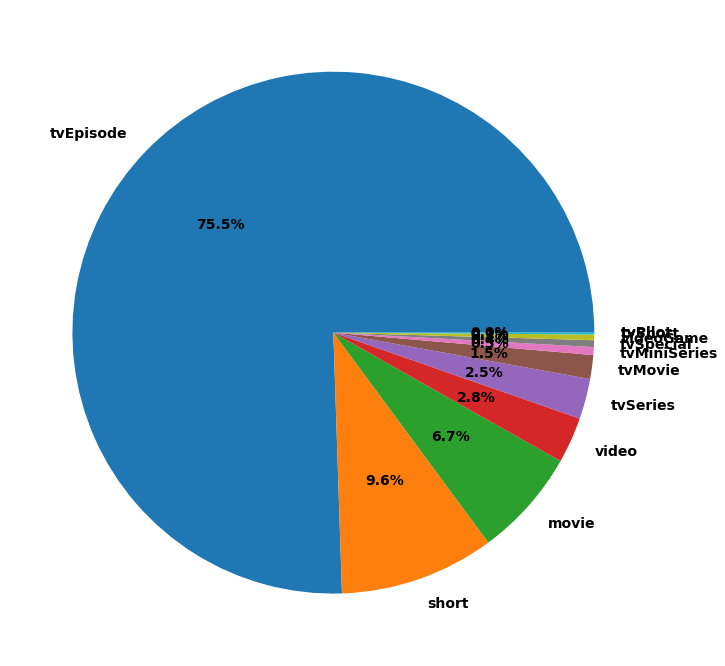

In [ ]:
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

fig = plt.figure(figsize =(12, 12))
plt.pie(title_basics.pandas_api().titleType.value_counts().values\
        ,autopct='%1.1f%%'\
        ,labels = title_basics.pandas_api().titleType.value_counts().keys().to_numpy())
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


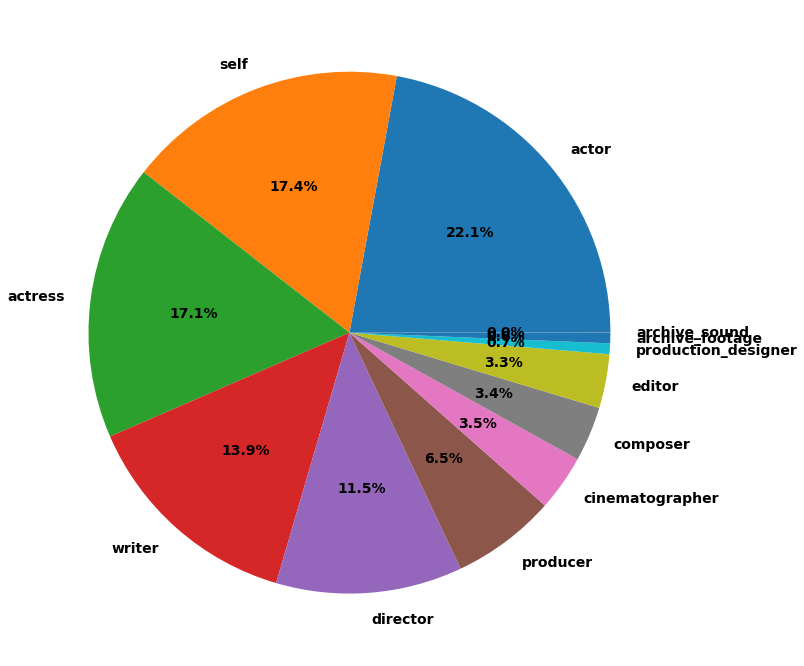

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

fig = plt.figure(figsize =(12, 12))
plt.pie(title_principals.pandas_api().category.value_counts().values\
        ,autopct='%1.1f%%'\
        ,labels = title_principals.pandas_api().category.value_counts().keys().to_numpy())
plt.show()

# Dataset informations

In [ ]:
movie_for_count = spark.sparkContext.textFile(name = "/content/title.basics.tsv/data.tsv", minPartitions = 2)

total = movie_for_count.map(lambda x:x[0]).count()
print(f"total number of entries in dataset title.basics: {total}\n")

movie_for_count = title_basics.rdd.map(lambda x: x[1]).filter(lambda x: x == "movie").count()
print(f"total number of movies: {movie_for_count}\n")

total number of nodes: 9389357

total number of movies: 627705



In [ ]:
actors_for_count = spark.sparkContext.textFile(name = "/content/title.principals.tsv/data.tsv", minPartitions = 2)

total = actors_for_count.map(lambda x:x[0]).count()
print(f"total number of entries in dataset title.principals: {total}\n")

actors = title_principals.rdd.map(lambda x: x[3]).filter(lambda x: x == "actor").count()
print(f"total number of actors: {actors}\n")

actress = title_principals.rdd.map(lambda x: x[3]).filter(lambda x: x == "actress").count()
print(f"total number of actress: {actress}\n")

self_actor = title_principals.rdd.map(lambda x: x[3]).filter(lambda x: x == "self").count()
print(f"total number of self: {self_actor}\n")

total number of nodes: 53173248



# Preparing the dataset

In [ ]:
title_basics.createOrReplaceTempView("title_basics")
title_principals.createOrReplaceTempView("title_principals") # queste due sono necessarie?

sql_df = spark.sql("Select t1.*, t2.* from title_principals as t1 INNER JOIN title_basics as t2 ON t1.tconst = t2.tconst where t2.titleType= 'movie'")

In [ ]:
dataset = sql_df.rdd.map(lambda x: ( int(x[0][2:]) , x[2], x[3], x[14]))\
                   .filter(lambda x: x[3] == "Drama,Romance") \
                   .filter(lambda x: x[2] == "actor" or x[2] == "actress" or x[2] == "self")\
                   .map(lambda x: (x[1], x[0]))\
                   .groupByKey()\
                   .map(lambda x : (x[0], list(x[1])))

In [ ]:
dataset = dataset.map(lambda x: [(a, b) for a in x[1] for b in x[1] if a!=b]).flatMap(lambda x: x).distinct()

In [ ]:
nodes = dataset.sortBy(lambda x: x[0]).map(lambda x: x[0]).distinct()
num_nodes = nodes.count()
num_nodes

In [ ]:
indexes = nodes.zipWithIndex().map(lambda x: ( x[0], x[1] + 1 ) )

collection_indexes = OrderedDict(indexes.collect())

dataset = dataset.map(lambda x: ( collection_indexes[x[0]], collection_indexes[x[1]] ) )

[(4321, 1), (6728, 2), (7105, 3), (7221, 4), (8468, 5)]

In [ ]:
num_edges = dataset.count()
num_edges

153350

# Function - Similarity

In [ ]:
def compute_similarity(a, b, threshold: int = 4):
    total = 0
    for item in a:
        if item in b:
            for i in range(0,threshold):
                if a.index(item) == abs((i - b.index(item))) or a.index(item) == (i + b.index(item)):
                    total +=1
                    break
    return total/len(a), total

# GraphFrame library

In [ ]:
row = Row("id")
n = dataset.map(lambda x: x[0]).distinct()
v = n.map(row).toDF()

e = dataset.toDF(["src", "dst"]).dropDuplicates()

graph = GraphFrame(v, e) 

In [ ]:
graphframes_pagerank_e1 = graph.pageRank(resetProbability=0.15, tol = 0.1)
graphframes_pagerank_e2 = graph.pageRank(resetProbability=0.15, tol = 0.01)
graphframes_pagerank_e3 = graph.pageRank(resetProbability=0.15, tol = 0.001)
graphframes_pagerank_e4 = graph.pageRank(resetProbability=0.15, tol = 0.0001)
graphframes_pagerank_e5 = graph.pageRank(resetProbability=0.15, tol = 0.00001)
graphframes_pagerank_e6 = graph.pageRank(resetProbability=0.15, tol = 0.000001)
graphframes_pagerank_e7 = graph.pageRank(resetProbability=0.15, tol = 0.0000001)
graphframes_pagerank_e8 = graph.pageRank(resetProbability=0.15, tol = 0.00000001)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [ ]:
gf_1_20 = graphframes_pagerank_e1.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
gf_01_20 = graphframes_pagerank_e2.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
gf_001_20 = graphframes_pagerank_e3.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
gf_0001_20 = graphframes_pagerank_e4.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
gf_00001_20 = graphframes_pagerank_e5.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
gf_000001_20 = graphframes_pagerank_e6.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
gf_0000001_20 = graphframes_pagerank_e7.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
gf_00000001_20 = graphframes_pagerank_e8.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)

compute_similarity(gf_1_20, gf_01_20, 2), compute_similarity(gf_01_20, gf_001_20, 2), compute_similarity(gf_001_20, gf_0001_20, 2), compute_similarity(gf_0001_20, gf_00001_20, 2), compute_similarity(gf_00001_20, gf_000001_20, 2), compute_similarity(gf_000001_20, gf_0000001_20, 2), compute_similarity(gf_0000001_20, gf_00000001_20, 2)

((0.3, 6), (0.75, 15), (1.0, 20), (1.0, 20), (1.0, 20), (1.0, 20), (1.0, 20))

In [ ]:
x_gf = ["10e-1 - 10e-2", "10e-2 - 10e-3", "10e-3 - 10e-4", "10e-4 - 10e-5", "10e-5 - 10e-6", "10e-6 - 10e-7", "10e-7 - 10e-8"]
y_gf_20 = [compute_similarity(gf_1_20, gf_01_20, 2)[0], compute_similarity(gf_01_20, gf_001_20, 2)[0], compute_similarity(gf_001_20, gf_0001_20, 2)[0], compute_similarity(gf_0001_20, gf_00001_20, 2)[0], compute_similarity(gf_00001_20, gf_000001_20, 2)[0], compute_similarity(gf_000001_20, gf_0000001_20, 2)[0], compute_similarity(gf_0000001_20, gf_00000001_20, 2)[0]]

In [ ]:
gf_1_50 = graphframes_pagerank_e1.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)
gf_01_50 = graphframes_pagerank_e2.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)
gf_001_50 = graphframes_pagerank_e3.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)
gf_0001_50 = graphframes_pagerank_e4.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)
gf_00001_50 = graphframes_pagerank_e5.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)
gf_000001_50 = graphframes_pagerank_e6.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)
gf_0000001_50 = graphframes_pagerank_e7.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)
gf_00000001_50 = graphframes_pagerank_e8.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(50)

compute_similarity(gf_1_50, gf_01_50, 2), compute_similarity(gf_01_50, gf_001_50, 2), compute_similarity(gf_001_50, gf_0001_50, 2), compute_similarity(gf_0001_50, gf_00001_50, 2), compute_similarity(gf_00001_50, gf_000001_50, 2), compute_similarity(gf_000001_50, gf_0000001_50, 2), compute_similarity(gf_0000001_50, gf_00000001_50, 2)

((0.16, 8), (0.58, 29), (0.98, 49), (1.0, 50), (1.0, 50), (1.0, 50), (1.0, 50))

In [ ]:
y_gf_50 = [compute_similarity(gf_1_50, gf_01_50, 2)[0], compute_similarity(gf_01_50, gf_001_50, 2)[0], compute_similarity(gf_001_50, gf_0001_50, 2)[0], compute_similarity(gf_0001_50, gf_00001_50, 2)[0], compute_similarity(gf_00001_50, gf_000001_50, 2)[0], compute_similarity(gf_000001_50, gf_0000001_50, 2)[0], compute_similarity(gf_0000001_50, gf_00000001_50, 2)[0]]

In [ ]:
gf_1_100 = graphframes_pagerank_e1.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)
gf_01_100 = graphframes_pagerank_e2.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)
gf_001_100 = graphframes_pagerank_e3.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)
gf_0001_100 = graphframes_pagerank_e4.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)
gf_00001_100 = graphframes_pagerank_e5.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)
gf_000001_100 = graphframes_pagerank_e6.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)
gf_0000001_100 = graphframes_pagerank_e7.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)
gf_00000001_100 = graphframes_pagerank_e8.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(100)

compute_similarity(gf_1_100, gf_01_100, 2), compute_similarity(gf_01_100, gf_001_100, 2), compute_similarity(gf_001_100, gf_0001_100, 2), compute_similarity(gf_0001_100, gf_00001_100, 2), compute_similarity(gf_00001_100, gf_000001_100, 2), compute_similarity(gf_000001_100, gf_0000001_100, 2), compute_similarity(gf_0000001_100, gf_00000001_100, 2)

((0.11, 11),
 (0.39, 39),
 (0.93, 93),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100))

In [ ]:
y_gf_100 = [compute_similarity(gf_1_100, gf_01_100, 2)[0], compute_similarity(gf_01_100, gf_001_100, 2)[0], compute_similarity(gf_001_100, gf_0001_100, 2)[0], compute_similarity(gf_0001_100, gf_00001_100, 2)[0], compute_similarity(gf_00001_100, gf_000001_100, 2)[0], compute_similarity(gf_000001_100, gf_0000001_100, 2)[0], compute_similarity(gf_0000001_100, gf_00000001_100, 2)[0]]

In [ ]:
gf_1_500 = graphframes_pagerank_e1.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)
gf_01_500 = graphframes_pagerank_e2.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)
gf_001_500 = graphframes_pagerank_e3.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)
gf_0001_500 = graphframes_pagerank_e4.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)
gf_00001_500 = graphframes_pagerank_e5.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)
gf_000001_500 = graphframes_pagerank_e6.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)
gf_0000001_500 = graphframes_pagerank_e7.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)
gf_00000001_500 = graphframes_pagerank_e8.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(500)

compute_similarity(gf_1_500, gf_01_500, 2), compute_similarity(gf_01_500, gf_001_500, 2), compute_similarity(gf_001_500, gf_0001_500, 2), compute_similarity(gf_0001_500, gf_00001_500, 2), compute_similarity(gf_00001_500, gf_000001_500, 2), compute_similarity(gf_000001_500, gf_0000001_500, 2), compute_similarity(gf_0000001_500, gf_00000001_500, 2) 

((0.026, 13),
 (0.184, 92),
 (0.726, 363),
 (0.996, 498),
 (1.0, 500),
 (1.0, 500),
 (1.0, 500))

In [ ]:
y_gf_500 = [compute_similarity(gf_1_500, gf_01_500, 2)[0], compute_similarity(gf_01_500, gf_001_500, 2)[0], compute_similarity(gf_001_500, gf_0001_500, 2)[0], compute_similarity(gf_0001_500, gf_00001_500, 2)[0], compute_similarity(gf_00001_500, gf_000001_500, 2)[0], compute_similarity(gf_000001_500, gf_0000001_500, 2)[0], compute_similarity(gf_0000001_500, gf_00000001_500, 2)[0]]

In [ ]:
graphframes_pagerank_e8.vertices.orderBy("pagerank", ascending=False).show(20)

+----+------------------+
|  id|          pagerank|
+----+------------------+
|3341| 3.425495162291551|
|4979| 3.240624400723668|
|1672|3.0939642171423722|
|3648|2.9965779729940043|
|7103|2.9336711822340744|
|7827|2.9243179587115455|
|7553| 2.888360729264355|
|2878|2.8634965134529486|
|1419|2.8082956134015746|
|1008| 2.768292199329903|
|7411| 2.730176015544522|
|4419|2.7073796221394226|
|8612|2.7025311148182913|
|4644|2.6984642848232188|
|5397|2.6757261503374923|
|9110|2.6677914846604507|
| 440|2.6643420132245397|
|7445|2.6578339755787104|
|6886| 2.654369437373407|
|7329|2.6142271324938258|
+----+------------------+
only showing top 20 rows



# NetworkX library

In [ ]:
myGraph = nx.Graph()
myGraph = nx.from_pandas_edgelist(e.toPandas(), 'src', 'dst')

In [ ]:
networkx_pagerank_e3 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-3)
networkx_pagerank_e4 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-4)
networkx_pagerank_e5 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-5)
networkx_pagerank_e6 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-6)
networkx_pagerank_e7 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-7)
networkx_pagerank_e8 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-8)
networkx_pagerank_e9 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-9)
networkx_pagerank_e10 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-10)
networkx_pagerank_e11 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-11)
networkx_pagerank_e12 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-12)
networkx_pagerank_e13 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-13)
networkx_pagerank_e14 = nx.pagerank(myGraph, alpha=0.85, tol = 10e-14)

In [ ]:
sorted_networkx_pagerank_e3 = dict(sorted(networkx_pagerank_e3.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e4 = dict(sorted(networkx_pagerank_e4.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e5 = dict(sorted(networkx_pagerank_e5.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e6 = dict(sorted(networkx_pagerank_e6.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e7 = dict(sorted(networkx_pagerank_e7.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e8 = dict(sorted(networkx_pagerank_e8.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e9 = dict(sorted(networkx_pagerank_e9.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e10 = dict(sorted(networkx_pagerank_e10.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e11 = dict(sorted(networkx_pagerank_e11.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e12 = dict(sorted(networkx_pagerank_e12.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e13 = dict(sorted(networkx_pagerank_e13.items(), key=lambda item: item[1], reverse=True))
sorted_networkx_pagerank_e14 = dict(sorted(networkx_pagerank_e14.items(), key=lambda item: item[1], reverse=True))

In [ ]:
net_e3 = list(sorted_networkx_pagerank_e3.items())[:20]
net_e3 = [i[0] for i in net_e3]
net_e4 = list(sorted_networkx_pagerank_e4.items())[:20]
net_e4 = [i[0] for i in net_e4]
net_e5 = list(sorted_networkx_pagerank_e5.items())[:20]
net_e5 = [i[0] for i in net_e5]
net_e6 = list(sorted_networkx_pagerank_e6.items())[:20]
net_e6 = [i[0] for i in net_e6]
net_e7 = list(sorted_networkx_pagerank_e7.items())[:20]
net_e7 = [i[0] for i in net_e7]
net_e8 = list(sorted_networkx_pagerank_e8.items())[:20]
net_e8 = [i[0] for i in net_e8]
net_e9 = list(sorted_networkx_pagerank_e9.items())[:20]
net_e9 = [i[0] for i in net_e9]
net_e10 = list(sorted_networkx_pagerank_e10.items())[:20]
net_e10 = [i[0] for i in net_e10]
net_e11 = list(sorted_networkx_pagerank_e11.items())[:20]
net_e11 = [i[0] for i in net_e11]
net_e12 = list(sorted_networkx_pagerank_e12.items())[:20]
net_e12 = [i[0] for i in net_e12]
net_e13 = list(sorted_networkx_pagerank_e13.items())[:20]
net_e13 = [i[0] for i in net_e13]
net_e14 = list(sorted_networkx_pagerank_e14.items())[:20]
net_e14 = [i[0] for i in net_e14]

compute_similarity(net_e3, net_e4, 2), compute_similarity(net_e4, net_e5, 2), compute_similarity(net_e5, net_e6, 2), compute_similarity(net_e6, net_e7, 2), compute_similarity(net_e7, net_e8, 2), compute_similarity(net_e8, net_e9, 2),  compute_similarity(net_e9, net_e10, 2), compute_similarity(net_e10, net_e11, 2), compute_similarity(net_e11, net_e12, 2), compute_similarity(net_e12, net_e13, 2), compute_similarity(net_e13, net_e14, 2)

((1.0, 20),
 (1.0, 20),
 (0.05, 1),
 (0.3, 6),
 (0.55, 11),
 (1.0, 20),
 (0.95, 19),
 (1.0, 20),
 (1.0, 20),
 (1.0, 20),
 (1.0, 20))

In [ ]:
x_net = ["10e-3 - 10e-4", "10e-4 - 10e-5", "10e-5 - 10e-6", "10e-6 - 10e-7", "10e-7 - 10e-8", "10e-8 - 10e-9", "10e-9 - 10e-10", "10e-10 - 10e-11", "10e-11 - 10e-12", "10e-12 - 10e-13", "10e-13 - 10e-14"]
y_net_20 = [compute_similarity(net_e3, net_e4, 2)[0], compute_similarity(net_e4, net_e5, 2)[0], compute_similarity(net_e5, net_e6, 2)[0], compute_similarity(net_e6, net_e7, 2)[0], compute_similarity(net_e7, net_e8, 2)[0], compute_similarity(net_e8, net_e9, 2)[0],  compute_similarity(net_e9, net_e10, 2)[0], compute_similarity(net_e10, net_e11, 2)[0], compute_similarity(net_e11, net_e12, 2)[0], compute_similarity(net_e12, net_e13, 2)[0], compute_similarity(net_e13, net_e14, 2)[0]]

In [ ]:
net_e3_50 = list(sorted_networkx_pagerank_e3.items())[:50]
net_e3_50 = [i[0] for i in net_e3_50]
net_e4_50 = list(sorted_networkx_pagerank_e4.items())[:50]
net_e4_50 = [i[0] for i in net_e4_50]
net_e5_50 = list(sorted_networkx_pagerank_e5.items())[:50]
net_e5_50 = [i[0] for i in net_e5_50]
net_e6_50 = list(sorted_networkx_pagerank_e6.items())[:50]
net_e6_50 = [i[0] for i in net_e6_50]
net_e7_50 = list(sorted_networkx_pagerank_e7.items())[:50]
net_e7_50 = [i[0] for i in net_e7_50]
net_e8_50 = list(sorted_networkx_pagerank_e8.items())[:50]
net_e8_50 = [i[0] for i in net_e8_50]
net_e9_50 = list(sorted_networkx_pagerank_e9.items())[:50]
net_e9_50 = [i[0] for i in net_e9_50]
net_e10_50 = list(sorted_networkx_pagerank_e10.items())[:50]
net_e10_50 = [i[0] for i in net_e10_50]
net_e11_50 = list(sorted_networkx_pagerank_e11.items())[:50]
net_e11_50 = [i[0] for i in net_e11_50]
net_e12_50 = list(sorted_networkx_pagerank_e12.items())[:50]
net_e12_50 = [i[0] for i in net_e12_50]
net_e13_50 = list(sorted_networkx_pagerank_e13.items())[:50]
net_e13_50 = [i[0] for i in net_e13_50]
net_e14_50 = list(sorted_networkx_pagerank_e14.items())[:50]
net_e14_50 = [i[0] for i in net_e14_50]

compute_similarity(net_e3_50, net_e4_50, 2), compute_similarity(net_e4_50, net_e5_50, 2), compute_similarity(net_e5_50, net_e6_50, 2), compute_similarity(net_e6_50, net_e7_50, 2), compute_similarity(net_e7_50, net_e8_50, 2), compute_similarity(net_e8_50, net_e9_50, 2), compute_similarity(net_e9_50, net_e10_50, 2), compute_similarity(net_e10_50, net_e11_50, 2), compute_similarity(net_e11_50, net_e12_50, 2), compute_similarity(net_e12_50, net_e13_50, 2), compute_similarity(net_e13_50, net_e14_50, 2)

((1.0, 50),
 (1.0, 50),
 (0.04, 2),
 (0.22, 11),
 (0.34, 17),
 (0.96, 48),
 (1.0, 50),
 (1.0, 50),
 (1.0, 50),
 (1.0, 50),
 (1.0, 50))

In [ ]:
y_net_50 =  [compute_similarity(net_e3_50, net_e4_50, 2)[0], compute_similarity(net_e4_50, net_e5_50, 2)[0], compute_similarity(net_e5_50, net_e6_50, 2)[0], compute_similarity(net_e6_50, net_e7_50, 2)[0], compute_similarity(net_e7_50, net_e8_50, 2)[0], compute_similarity(net_e8_50, net_e9_50, 2)[0], compute_similarity(net_e9_50, net_e10_50, 2)[0], compute_similarity(net_e10_50, net_e11_50, 2)[0], compute_similarity(net_e11_50, net_e12_50, 2)[0], compute_similarity(net_e12_50, net_e13_50, 2)[0], compute_similarity(net_e13_50, net_e14_50, 2)[0]]

In [ ]:
net_e3_100 = list(sorted_networkx_pagerank_e3.items())[:100]
net_e3_100 = [i[0] for i in net_e3_100]
net_e4_100 = list(sorted_networkx_pagerank_e4.items())[:100]
net_e4_100 = [i[0] for i in net_e4_100]
net_e5_100 = list(sorted_networkx_pagerank_e5.items())[:100]
net_e5_100 = [i[0] for i in net_e5_100]
net_e6_100 = list(sorted_networkx_pagerank_e6.items())[:100]
net_e6_100 = [i[0] for i in net_e6_100]
net_e7_100 = list(sorted_networkx_pagerank_e7.items())[:100]
net_e7_100 = [i[0] for i in net_e7_100]
net_e8_100 = list(sorted_networkx_pagerank_e8.items())[:100]
net_e8_100 = [i[0] for i in net_e8_100]
net_e9_100 = list(sorted_networkx_pagerank_e9.items())[:100]
net_e9_100 = [i[0] for i in net_e9_100]
net_e10_100 = list(sorted_networkx_pagerank_e10.items())[:100]
net_e10_100 = [i[0] for i in net_e10_100]
net_e11_100 = list(sorted_networkx_pagerank_e11.items())[:100]
net_e11_100 = [i[0] for i in net_e11_100]
net_e12_100 = list(sorted_networkx_pagerank_e12.items())[:100]
net_e12_100 = [i[0] for i in net_e12_100]
net_e13_100 = list(sorted_networkx_pagerank_e13.items())[:100]
net_e13_100 = [i[0] for i in net_e13_100]
net_e14_100 = list(sorted_networkx_pagerank_e14.items())[:100]
net_e14_100 = [i[0] for i in net_e14_100]

compute_similarity(net_e3_100, net_e4_100, 2), compute_similarity(net_e4_100, net_e5_100, 2), compute_similarity(net_e5_100, net_e6_100, 2), compute_similarity(net_e6_100, net_e7_100, 2), compute_similarity(net_e7_100, net_e8_100, 2), compute_similarity(net_e8_100, net_e9_100, 2), compute_similarity(net_e9_100, net_e10_100, 2), compute_similarity(net_e10_100, net_e11_100, 2), compute_similarity(net_e11_100, net_e12_100, 2), compute_similarity(net_e12_100, net_e13_100, 2), compute_similarity(net_e13_100, net_e14_100, 2)

((1.0, 100),
 (1.0, 100),
 (0.02, 2),
 (0.11, 11),
 (0.23, 23),
 (0.88, 88),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100))

In [ ]:
y_net_100 =  [compute_similarity(net_e3_100, net_e4_100, 2)[0], compute_similarity(net_e4_100, net_e5_100, 2)[0], compute_similarity(net_e5_100, net_e6_100, 2)[0], compute_similarity(net_e6_100, net_e7_100, 2)[0], compute_similarity(net_e7_100, net_e8_100, 2)[0], compute_similarity(net_e8_100, net_e9_100, 2)[0], compute_similarity(net_e9_100, net_e10_100, 2)[0], compute_similarity(net_e10_100, net_e11_100, 2)[0], compute_similarity(net_e11_100, net_e12_100, 2)[0], compute_similarity(net_e12_100, net_e13_100, 2)[0], compute_similarity(net_e13_100, net_e14_100, 2)[0]]

In [ ]:
net_e3_500 = list(sorted_networkx_pagerank_e3.items())[:500]
net_e3_500 = [i[0] for i in net_e3_500]
net_e4_500 = list(sorted_networkx_pagerank_e4.items())[:500]
net_e4_500 = [i[0] for i in net_e4_500]
net_e5_500 = list(sorted_networkx_pagerank_e5.items())[:500]
net_e5_500 = [i[0] for i in net_e5_500]
net_e6_500 = list(sorted_networkx_pagerank_e6.items())[:500]
net_e6_500 = [i[0] for i in net_e6_500]
net_e7_500 = list(sorted_networkx_pagerank_e7.items())[:500]
net_e7_500 = [i[0] for i in net_e7_500]
net_e8_500 = list(sorted_networkx_pagerank_e8.items())[:500]
net_e8_500 = [i[0] for i in net_e8_500]
net_e9_500 = list(sorted_networkx_pagerank_e9.items())[:500]
net_e9_500 = [i[0] for i in net_e9_500]
net_e10_500 = list(sorted_networkx_pagerank_e10.items())[:500]
net_e10_500 = [i[0] for i in net_e10_500]
net_e11_500 = list(sorted_networkx_pagerank_e11.items())[:500]
net_e11_500 = [i[0] for i in net_e11_500]
net_e12_500 = list(sorted_networkx_pagerank_e12.items())[:500]
net_e12_500 = [i[0] for i in net_e12_500]
net_e13_500 = list(sorted_networkx_pagerank_e13.items())[:500]
net_e13_500 = [i[0] for i in net_e13_500]
net_e14_500 = list(sorted_networkx_pagerank_e14.items())[:500]
net_e14_500 = [i[0] for i in net_e14_500]

compute_similarity(net_e3_500, net_e4_500, 2), compute_similarity(net_e4_500, net_e5_500, 2), compute_similarity(net_e5_500, net_e6_500, 2), compute_similarity(net_e6_500, net_e7_500, 2), compute_similarity(net_e7_500, net_e8_500, 2), compute_similarity(net_e8_500, net_e9_500, 2), compute_similarity(net_e9_500, net_e10_500, 2), compute_similarity(net_e10_500, net_e11_500, 2), compute_similarity(net_e11_500, net_e12_500, 2), compute_similarity(net_e12_500, net_e13_500, 2), compute_similarity(net_e13_500, net_e14_500, 2)

((1.0, 500),
 (1.0, 500),
 (0.006, 3),
 (0.042, 21),
 (0.09, 45),
 (0.55, 275),
 (0.968, 484),
 (1.0, 500),
 (1.0, 500),
 (1.0, 500),
 (1.0, 500))

In [ ]:
y_net_500 = [compute_similarity(net_e3_500, net_e4_500, 2)[0], compute_similarity(net_e4_500, net_e5_500, 2)[0], compute_similarity(net_e5_500, net_e6_500, 2)[0], compute_similarity(net_e6_500, net_e7_500, 2)[0], compute_similarity(net_e7_500, net_e8_500, 2)[0], compute_similarity(net_e8_500, net_e9_500, 2)[0], compute_similarity(net_e9_500, net_e10_500, 2)[0], compute_similarity(net_e10_500, net_e11_500, 2)[0], compute_similarity(net_e11_500, net_e12_500, 2)[0], compute_similarity(net_e12_500, net_e13_500, 2)[0], compute_similarity(net_e13_500, net_e14_500, 2)[0]]

In [ ]:
list(sorted_networkx_pagerank_e14.items())[:20]

[(3341, 0.0003605784404288328),
 (4979, 0.0003411183641711883),
 (1672, 0.00032568044429080224),
 (3648, 0.0003154292640299934),
 (7103, 0.0003088074995238225),
 (7827, 0.00030782294332155576),
 (7553, 0.00030403797479341347),
 (2878, 0.00030142068581815926),
 (1419, 0.00029561006953539174),
 (1008, 0.0002913991795109919),
 (7411, 0.0002873869544222339),
 (4419, 0.0002849873367875038),
 (8612, 0.00028447695638902806),
 (4644, 0.00028404887578329253),
 (5397, 0.00028165538908527746),
 (9110, 0.0002808201599354738),
 (440, 0.00028045705859026536),
 (7445, 0.00027977200040561463),
 (6886, 0.0002794073126552864),
 (7329, 0.0002751818071458392)]

# From scratch method - sum to 1

In [ ]:
out_degree = dataset.countByKey()

M = dataset.map(lambda x:(x[0],x[1],1/out_degree[x[0]]))

In [ ]:
def compute_distance(old_vct,new_vct):
    old_vct = list(old_vct.values())
    new_vct = list(new_vct.values())
    result = sum([(a - b)**2 for a, b in zip(old_vct, new_vct)])
    #print(result)
    return result

def compute_page_rank_n(M, nodes_count, damping_factor: float = 0.85, max_iter: int = 1000000, tolerance = 10e-7):

    MT = M.map(lambda x: (x[0], x[1], damping_factor * x[2] ))#+ (1 - damping_factor) / nodes_count))
    
    vct = dict(MT.map(lambda x: (x[0],1/num_nodes)).collect())
    old_vct = dict(MT.map(lambda x: (x[0],50)).collect())
    i=1
    while i <= max_iter and compute_distance(old_vct, vct) >= tolerance:
        new_vct = MT.map(lambda x:(x[1],(x[2]*vct[x[0]])))\
                      .reduceByKey(lambda x,y: x+y)
        old_vct = vct
        vct = dict(new_vct.map(lambda x: (x[0], x[1] + (1-damping_factor)/nodes_count ) ).collect())   #)).collect()) 
        i+=1
    print(tolerance, i, compute_distance(old_vct, vct))
    return vct, i

In [ ]:
scratch_e3 = compute_page_rank_n(M, num_nodes, tolerance = 10e-3)
scratch_e4 = compute_page_rank_n(M, num_nodes, tolerance = 10e-4)
scratch_e5 = compute_page_rank_n(M, num_nodes, tolerance = 10e-5)
scratch_e6 = compute_page_rank_n(M, num_nodes, tolerance = 10e-6)
scratch_e7 = compute_page_rank_n(M, num_nodes, tolerance = 10e-7)
scratch_e8 = compute_page_rank_n(M, num_nodes, tolerance = 10e-8)
scratch_e9 = compute_page_rank_n(M, num_nodes, tolerance = 10e-9)
scratch_e10 = compute_page_rank_n(M, num_nodes, tolerance = 10e-10)
scratch_e11 = compute_page_rank_n(M, num_nodes, tolerance = 10e-11)
scratch_e12 = compute_page_rank_n(M, num_nodes, tolerance = 10e-12)
scratch_e13 = compute_page_rank_n(M, num_nodes, tolerance = 10e-13)
scratch_e14 = compute_page_rank_n(M, num_nodes, tolerance = 10e-14)

0.01 2 1.896116164780673e-05
0.001 2 1.896116164780673e-05
0.0001 2 1.896116164780673e-05
1e-05 3 4.6681917067625785e-06
1e-06 5 5.623430476457147e-07
1e-07 9 7.124107830338669e-08
1e-08 15 8.042028047784225e-09
1e-09 22 7.790886016443586e-10
1e-10 29 7.901827214939311e-11
1e-11 36 8.079144149793394e-12
1e-12 43 8.288578545241253e-13
1e-13 50 8.509990734284093e-14


In [ ]:
x_iterations = [10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 10e-9, 10e-10, 10e-11, 10e-12, 10e-13, 10e-14]
y_iterations = [scratch_e3[1], scratch_e4[1], scratch_e5[1], scratch_e6[1], scratch_e7[1], scratch_e8[1], scratch_e9[1], scratch_e10[1],scratch_e11[1], scratch_e12[1], scratch_e13[1], scratch_e14[1]]

In [ ]:
scratch_e3 = dict(sorted(scratch_e3[0].items(), key=lambda item: item[1], reverse=True))
scratch_e4 = dict(sorted(scratch_e4[0].items(), key=lambda item: item[1], reverse=True))
scratch_e5 = dict(sorted(scratch_e5[0].items(), key=lambda item: item[1], reverse=True))
scratch_e6 = dict(sorted(scratch_e6[0].items(), key=lambda item: item[1], reverse=True))
scratch_e7 = dict(sorted(scratch_e7[0].items(), key=lambda item: item[1], reverse=True))
scratch_e8 = dict(sorted(scratch_e8[0].items(), key=lambda item: item[1], reverse=True))
scratch_e9 = dict(sorted(scratch_e9[0].items(), key=lambda item: item[1], reverse=True))
scratch_e10 = dict(sorted(scratch_e10[0].items(), key=lambda item: item[1], reverse=True))
scratch_e11 = dict(sorted(scratch_e11[0].items(), key=lambda item: item[1], reverse=True))
scratch_e12 = dict(sorted(scratch_e12[0].items(), key=lambda item: item[1], reverse=True))
scratch_e13 = dict(sorted(scratch_e13[0].items(), key=lambda item: item[1], reverse=True))
scratch_e14 = dict(sorted(scratch_e14[0].items(), key=lambda item: item[1], reverse=True))

In [ ]:
appo_3 = sum(list(scratch_e3.values()))
appo_4 = sum(list(scratch_e4.values()))
appo_5 = sum(list(scratch_e5.values()))
appo_6 = sum(list(scratch_e6.values()))
appo_7 = sum(list(scratch_e7.values()))
appo_8 = sum(list(scratch_e8.values()))
appo_9 = sum(list(scratch_e9.values()))
appo_10 = sum(list(scratch_e10.values()))
appo_11 = sum(list(scratch_e11.values()))
appo_12 = sum(list(scratch_e12.values()))
appo_13 = sum(list(scratch_e13.values()))
appo_14 = sum(list(scratch_e14.values()))

x_difference = [10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 10e-9, 10e-10, 10e-11, 10e-12, 10e-13, 10e-14]
y_difference = [1 - appo_3, 1 - appo_4, 1 - appo_5, 1 - appo_6, 1 - appo_7, 1 - appo_8, 1 - appo_9, 1 - appo_10,  1 - appo_11, 1 - appo_12,  1 - appo_13, 1 - appo_14]

1 - appo_3, 1 - appo_4, 1 - appo_5, 1 - appo_6, 1 - appo_7, 1 - appo_8, 1 - appo_9, 1 - appo_10,  1 - appo_11, 1 - appo_12,  1 - appo_13, 1 - appo_14

(1.5210055437364645e-14,
 1.5210055437364645e-14,
 1.5210055437364645e-14,
 3.219646771412954e-15,
 7.216449660063518e-15,
 1.1102230246251565e-14,
 1.5987211554602254e-14,
 1.4988010832439613e-14,
 9.2148511043888e-15,
 1.6653345369377348e-14,
 1.3766765505351941e-14,
 9.769962616701378e-15)

In [ ]:
sc_e3_20 = list(scratch_e3.keys())[:20]
sc_e4_20 = list(scratch_e4.keys())[:20]
sc_e5_20 = list(scratch_e5.keys())[:20]
sc_e6_20 = list(scratch_e6.keys())[:20]
sc_e7_20 = list(scratch_e7.keys())[:20]
sc_e8_20 = list(scratch_e8.keys())[:20]
sc_e9_20 = list(scratch_e9.keys())[:20]
sc_e10_20 = list(scratch_e10.keys())[:20]
sc_e11_20 = list(scratch_e11.keys())[:20]
sc_e12_20 = list(scratch_e12.keys())[:20]
sc_e13_20 = list(scratch_e13.keys())[:20]
sc_e14_20 = list(scratch_e14.keys())[:20]

compute_similarity(sc_e3_20, sc_e4_20, 2), compute_similarity(sc_e4_20, sc_e5_20, 2), compute_similarity(sc_e5_20, sc_e6_20, 2), compute_similarity(sc_e6_20, sc_e7_20, 2), compute_similarity(sc_e7_20, sc_e8_20, 2), compute_similarity(sc_e8_20, sc_e9_20, 2), compute_similarity(sc_e9_20, sc_e10_20, 2), compute_similarity(sc_e10_20, sc_e11_20, 2), compute_similarity(sc_e11_20, sc_e12_20, 2), compute_similarity(sc_e12_20, sc_e13_20, 2), compute_similarity(sc_e13_20, sc_e14_20, 2)

((1.0, 20),
 (1.0, 20),
 (0.0, 0),
 (0.35, 7),
 (0.45, 9),
 (0.55, 11),
 (0.9, 18),
 (1.0, 20),
 (0.95, 19),
 (1.0, 20),
 (1.0, 20))

In [ ]:
x_scratch = ["10e-3 - 10e-4", "10e-4 - 10e-5", "10e-5 - 10e-6", "10e-6 - 10e-7", "10e-7 - 10e-8", "10e-8 - 10e-9", "10e-9 - 10e-10", "10e-10 - 10e-11", "10e-11 - 10e-12", "10e-12 - 10e-13", "10e-13 - 10e-14"]
y_scratch_20 = [compute_similarity(sc_e3_20, sc_e4_20, 2)[0], compute_similarity(sc_e4_20, sc_e5_20, 2)[0], compute_similarity(sc_e5_20, sc_e6_20, 2)[0], compute_similarity(sc_e6_20, sc_e7_20, 2)[0], compute_similarity(sc_e7_20, sc_e8_20, 2)[0], compute_similarity(sc_e8_20, sc_e9_20, 2)[0], compute_similarity(sc_e9_20, sc_e10_20, 2)[0], compute_similarity(sc_e10_20, sc_e11_20, 2)[0], compute_similarity(sc_e11_20, sc_e12_20, 2)[0], compute_similarity(sc_e12_20, sc_e13_20, 2)[0], compute_similarity(sc_e13_20, sc_e14_20, 2)[0]]

In [ ]:
sc_e3_50 = list(scratch_e3.keys())[:50]
sc_e4_50 = list(scratch_e4.keys())[:50]
sc_e5_50 = list(scratch_e5.keys())[:50]
sc_e6_50 = list(scratch_e6.keys())[:50]
sc_e7_50 = list(scratch_e7.keys())[:50]
sc_e8_50 = list(scratch_e8.keys())[:50]
sc_e9_50 = list(scratch_e9.keys())[:50]
sc_e10_50 = list(scratch_e10.keys())[:50]
sc_e11_50 = list(scratch_e11.keys())[:50]
sc_e12_50 = list(scratch_e12.keys())[:50]
sc_e13_50 = list(scratch_e13.keys())[:50]
sc_e14_50 = list(scratch_e14.keys())[:50]

compute_similarity(sc_e3_50, sc_e4_50, 2), compute_similarity(sc_e4_50, sc_e5_50, 2), compute_similarity(sc_e5_50, sc_e6_50, 2), compute_similarity(sc_e6_50, sc_e7_50, 2), compute_similarity(sc_e7_50, sc_e8_50, 2), compute_similarity(sc_e8_50, sc_e9_50, 2), compute_similarity(sc_e9_50, sc_e10_50, 2), compute_similarity(sc_e10_50, sc_e11_50, 2), compute_similarity(sc_e11_50, sc_e12_50, 2), compute_similarity(sc_e12_50, sc_e13_50, 2), compute_similarity(sc_e13_50, sc_e14_50, 2)

((1.0, 50),
 (1.0, 50),
 (0.0, 0),
 (0.18, 9),
 (0.24, 12),
 (0.32, 16),
 (0.88, 44),
 (1.0, 50),
 (1.0, 50),
 (1.0, 50),
 (1.0, 50))

In [ ]:
y_scratch_50 = [compute_similarity(sc_e3_50, sc_e4_50, 2)[0], compute_similarity(sc_e4_50, sc_e5_50, 2)[0], compute_similarity(sc_e5_50, sc_e6_50, 2)[0], compute_similarity(sc_e6_50, sc_e7_50, 2)[0], compute_similarity(sc_e7_50, sc_e8_50, 2)[0], compute_similarity(sc_e8_50, sc_e9_50, 2)[0], compute_similarity(sc_e9_50, sc_e10_50, 2)[0], compute_similarity(sc_e10_50, sc_e11_50, 2)[0], compute_similarity(sc_e11_50, sc_e12_50, 2)[0], compute_similarity(sc_e12_50, sc_e13_50, 2)[0], compute_similarity(sc_e13_50, sc_e14_50, 2)[0]]

In [ ]:
sc_e3_100 = list(scratch_e3.keys())[:100]
sc_e4_100 = list(scratch_e4.keys())[:100]
sc_e5_100 = list(scratch_e5.keys())[:100]
sc_e6_100 = list(scratch_e6.keys())[:100]
sc_e7_100 = list(scratch_e7.keys())[:100]
sc_e8_100 = list(scratch_e8.keys())[:100]
sc_e9_100 = list(scratch_e9.keys())[:100]
sc_e10_100 = list(scratch_e10.keys())[:100]
sc_e11_100 = list(scratch_e11.keys())[:100]
sc_e12_100 = list(scratch_e12.keys())[:100]
sc_e13_100 = list(scratch_e13.keys())[:100]
sc_e14_100 = list(scratch_e14.keys())[:100]

compute_similarity(sc_e3_100, sc_e4_100, 2), compute_similarity(sc_e4_100, sc_e5_100, 2), compute_similarity(sc_e5_100, sc_e6_100, 2), compute_similarity(sc_e6_100, sc_e7_100, 2), compute_similarity(sc_e7_100, sc_e8_100, 2), compute_similarity(sc_e8_100, sc_e9_100, 2), compute_similarity(sc_e9_100, sc_e10_100, 2), compute_similarity(sc_e10_100, sc_e11_100, 2), compute_similarity(sc_e11_100, sc_e12_100, 2), compute_similarity(sc_e12_100, sc_e13_100, 2), compute_similarity(sc_e13_100, sc_e14_100, 2)

((1.0, 100),
 (1.0, 100),
 (0.0, 0),
 (0.11, 11),
 (0.14, 14),
 (0.24, 24),
 (0.74, 74),
 (0.96, 96),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100))

In [ ]:
y_scratch_100 = [compute_similarity(sc_e3_100, sc_e4_100, 2)[0], compute_similarity(sc_e4_100, sc_e5_100, 2)[0], compute_similarity(sc_e5_100, sc_e6_100, 2)[0], compute_similarity(sc_e6_100, sc_e7_100, 2)[0], compute_similarity(sc_e7_100, sc_e8_100, 2)[0], compute_similarity(sc_e8_100, sc_e9_100, 2)[0], compute_similarity(sc_e9_100, sc_e10_100, 2)[0], compute_similarity(sc_e10_100, sc_e11_100, 2)[0], compute_similarity(sc_e11_100, sc_e12_100, 2)[0], compute_similarity(sc_e12_100, sc_e13_100, 2)[0], compute_similarity(sc_e13_100, sc_e14_100, 2)[0]]

In [ ]:
sc_e3_500 = list(scratch_e3.keys())[:500]
sc_e4_500 = list(scratch_e4.keys())[:500]
sc_e5_500 = list(scratch_e5.keys())[:500]
sc_e6_500 = list(scratch_e6.keys())[:500]
sc_e7_500 = list(scratch_e7.keys())[:500]
sc_e8_500 = list(scratch_e8.keys())[:500]
sc_e9_500 = list(scratch_e9.keys())[:500]
sc_e10_500 = list(scratch_e10.keys())[:500]
sc_e11_500 = list(scratch_e11.keys())[:500]
sc_e12_500 = list(scratch_e12.keys())[:500]
sc_e13_500 = list(scratch_e13.keys())[:500]
sc_e14_500 = list(scratch_e14.keys())[:500]

compute_similarity(sc_e3_500, sc_e4_500, 2), compute_similarity(sc_e4_500, sc_e5_500, 2), compute_similarity(sc_e5_500, sc_e6_500, 2), compute_similarity(sc_e6_500, sc_e7_500, 2), compute_similarity(sc_e7_500, sc_e8_500, 2), compute_similarity(sc_e8_500, sc_e9_500, 2), compute_similarity(sc_e9_500, sc_e10_500, 2), compute_similarity(sc_e10_500, sc_e11_500, 2), compute_similarity(sc_e11_500, sc_e12_500, 2), compute_similarity(sc_e12_500, sc_e13_500, 2), compute_similarity(sc_e13_500, sc_e14_500, 2)

((1.0, 500),
 (1.0, 500),
 (0.006, 3),
 (0.028, 14),
 (0.058, 29),
 (0.092, 46),
 (0.356, 178),
 (0.77, 385),
 (0.952, 476),
 (0.994, 497),
 (0.998, 499))

In [ ]:
y_scratch_500 = [compute_similarity(sc_e3_500, sc_e4_500, 2)[0], compute_similarity(sc_e4_500, sc_e5_500, 2)[0], compute_similarity(sc_e5_500, sc_e6_500, 2)[0], compute_similarity(sc_e6_500, sc_e7_500, 2)[0], compute_similarity(sc_e7_500, sc_e8_500, 2)[0], compute_similarity(sc_e8_500, sc_e9_500, 2)[0], compute_similarity(sc_e9_500, sc_e10_500, 2)[0], compute_similarity(sc_e10_500, sc_e11_500, 2)[0], compute_similarity(sc_e11_500, sc_e12_500, 2)[0], compute_similarity(sc_e12_500, sc_e13_500, 2)[0], compute_similarity(sc_e13_500, sc_e14_500, 2)[0]]

In [ ]:
list(scratch_e14.items())[:20]

[(3341, 0.00036058094711481745),
 (4979, 0.000341117081503748),
 (1672, 0.00032567747629952295),
 (3648, 0.0003154313969977473),
 (7103, 0.00030880928997445076),
 (7827, 0.0003078200224019751),
 (7553, 0.00030403992070291493),
 (2878, 0.00030142317586070956),
 (1419, 0.00029561202325303546),
 (1008, 0.0002913964152355913),
 (7411, 0.00028738898686790247),
 (4419, 0.00028498915166219943),
 (8612, 0.00028447751661791066),
 (4644, 0.00028405055639713376),
 (5397, 0.000281655753377492),
 (9110, 0.0002808221076071773),
 (440, 0.00028045900249545777),
 (7445, 0.0002797715798144194),
 (6886, 0.0002794092583401302),
 (7329, 0.0002751804664200577)]

# From scratch method - sum to N


In [ ]:
scratch_e1_n = compute_page_rank_n(M, 1, tolerance = 10e-1)
scratch_e2_n = compute_page_rank_n(M, 1, tolerance = 10e-2)
scratch_e3_n = compute_page_rank_n(M, 1, tolerance = 10e-3)
scratch_e4_n = compute_page_rank_n(M, 1, tolerance = 10e-4)
scratch_e5_n = compute_page_rank_n(M, 1, tolerance = 10e-5)
scratch_e6_n = compute_page_rank_n(M, 1, tolerance = 10e-6)
scratch_e7_n = compute_page_rank_n(M, 1, tolerance = 10e-7)
scratch_e8_n = compute_page_rank_n(M, 1, tolerance = 10e-8)


1.0 20 0.8822222272086316
0.1 27 0.09282816409804111
0.01 34 0.009622428488883311
0.001 42 0.0007228879178263964
0.0001 49 7.52534840435194e-05
1e-05 56 7.7572080939222e-06
1e-06 63 8.060127145066506e-07
1e-07 70 8.298059949905137e-08


In [ ]:
x_iterations_n = [10e-1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8]
y_iterations_n = [scratch_e1_n[1], scratch_e2_n[1], scratch_e3_n[1], scratch_e4_n[1], scratch_e5_n[1], scratch_e6_n[1], scratch_e7_n[1],  scratch_e8_n[1]]

In [ ]:
scratch_e1_n = dict(sorted(scratch_e1_n[0].items(), key=lambda item: item[1], reverse=True))
scratch_e2_n = dict(sorted(scratch_e2_n[0].items(), key=lambda item: item[1], reverse=True))
scratch_e3_n = dict(sorted(scratch_e3_n[0].items(), key=lambda item: item[1], reverse=True))
scratch_e4_n = dict(sorted(scratch_e4_n[0].items(), key=lambda item: item[1], reverse=True))
scratch_e5_n = dict(sorted(scratch_e5_n[0].items(), key=lambda item: item[1], reverse=True))
scratch_e6_n = dict(sorted(scratch_e6_n[0].items(), key=lambda item: item[1], reverse=True))
scratch_e7_n = dict(sorted(scratch_e7_n[0].items(), key=lambda item: item[1], reverse=True))
scratch_e8_n = dict(sorted(scratch_e8_n[0].items(), key=lambda item: item[1], reverse=True))

In [ ]:
appo_1_n = sum(list(scratch_e1_n.values()))
appo_2_n = sum(list(scratch_e2_n.values()))
appo_3_n = sum(list(scratch_e3_n.values()))
appo_4_n = sum(list(scratch_e4_n.values()))
appo_5_n = sum(list(scratch_e5_n.values()))
appo_6_n = sum(list(scratch_e6_n.values()))
appo_7_n = sum(list(scratch_e7_n.values()))
appo_8_n = sum(list(scratch_e8_n.values()))

appo_1_n, appo_2_n, appo_3_n, appo_4_n, appo_5_n, appo_6_n, appo_7_n, appo_8_n

(9066.850840268531,
 9361.142303581759,
 9455.485403996669,
 9487.87019436337,
 9496.111462227364,
 9498.753423883272,
 9499.600376258168,
 9499.871889784228)

In [ ]:
x_difference_n = [10e-1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8]
y_difference_n = [num_nodes - appo_1_n, num_nodes - appo_2_n, num_nodes - appo_3_n, num_nodes - appo_4_n, num_nodes - appo_5_n, num_nodes - appo_6_n, num_nodes - appo_7_n, num_nodes - appo_8_n]

num_nodes - appo_1_n, num_nodes - appo_2_n, num_nodes - appo_3_n, num_nodes - appo_4_n, num_nodes - appo_5_n, num_nodes - appo_6_n, num_nodes - appo_7_n, num_nodes - appo_8_n

(433.1491597314689,
 138.85769641824118,
 44.51459600333146,
 12.129805636630408,
 3.8885377726364823,
 1.2465761167277378,
 0.39962374183232896,
 0.12811021577181236)

In [ ]:
sc_e1_20_n = list(scratch_e1_n.keys())[:20]
sc_e2_20_n = list(scratch_e2_n.keys())[:20]
sc_e3_20_n = list(scratch_e3_n.keys())[:20]
sc_e4_20_n = list(scratch_e4_n.keys())[:20]
sc_e5_20_n = list(scratch_e5_n.keys())[:20]
sc_e6_20_n = list(scratch_e6_n.keys())[:20]
sc_e7_20_n = list(scratch_e7_n.keys())[:20]
sc_e8_20_n = list(scratch_e8_n.keys())[:20]

compute_similarity(sc_e1_20_n, sc_e2_20_n, 2), compute_similarity(sc_e2_20_n, sc_e3_20_n, 2), compute_similarity(sc_e3_20_n, sc_e4_20_n, 2), compute_similarity(sc_e4_20_n, sc_e5_20_n, 2), compute_similarity(sc_e5_20_n, sc_e6_20_n, 2), compute_similarity(sc_e6_20_n, sc_e7_20_n, 2), compute_similarity(sc_e7_20_n, sc_e8_20_n, 2)


((0.85, 17), (1.0, 20), (1.0, 20), (0.95, 19), (1.0, 20), (1.0, 20), (1.0, 20))

In [ ]:
x_scratch_n = ["10e-1 - 10e-2", "10e-2 - 10e-3", "10e-3 - 10e-4", "10e-4 - 10e-5", "10e-5 - 10e-6", "10e-6 - 10e-7", "10e-7 - 10e-8"]
y_scratch_n_20 = [compute_similarity(sc_e1_20_n, sc_e2_20_n, 2)[0], compute_similarity(sc_e2_20_n, sc_e3_20_n, 2)[0], compute_similarity(sc_e3_20_n, sc_e4_20_n, 2)[0], compute_similarity(sc_e4_20_n, sc_e5_20_n, 2)[0], compute_similarity(sc_e5_20_n, sc_e6_20_n, 2)[0], compute_similarity(sc_e6_20_n, sc_e7_20_n, 2)[0], compute_similarity(sc_e7_20_n, sc_e8_20_n, 2)[0]]

In [ ]:
sc_e1_50_n = list(scratch_e1_n.keys())[:50]
sc_e2_50_n = list(scratch_e2_n.keys())[:50]
sc_e3_50_n = list(scratch_e3_n.keys())[:50]
sc_e4_50_n = list(scratch_e4_n.keys())[:50]
sc_e5_50_n = list(scratch_e5_n.keys())[:50]
sc_e6_50_n = list(scratch_e6_n.keys())[:50]
sc_e7_50_n = list(scratch_e7_n.keys())[:50]
sc_e8_50_n = list(scratch_e8_n.keys())[:50]

compute_similarity(sc_e1_50_n, sc_e2_50_n, 2), compute_similarity(sc_e2_50_n, sc_e3_50_n, 2), compute_similarity(sc_e3_50_n, sc_e4_50_n, 2), compute_similarity(sc_e4_50_n, sc_e5_50_n, 2), compute_similarity(sc_e5_50_n, sc_e6_50_n, 2), compute_similarity(sc_e6_50_n, sc_e7_50_n, 2), compute_similarity(sc_e7_50_n, sc_e8_50_n, 2)


((0.66, 33), (0.88, 44), (1.0, 50), (1.0, 50), (1.0, 50), (1.0, 50), (1.0, 50))

In [ ]:
y_scratch_n_50 = [compute_similarity(sc_e1_50_n, sc_e2_50_n, 2)[0], compute_similarity(sc_e2_50_n, sc_e3_50_n, 2)[0], compute_similarity(sc_e3_50_n, sc_e4_50_n, 2)[0], compute_similarity(sc_e4_50_n, sc_e5_50_n, 2)[0], compute_similarity(sc_e5_50_n, sc_e6_50_n, 2)[0], compute_similarity(sc_e6_50_n, sc_e7_50_n, 2)[0], compute_similarity(sc_e7_50_n, sc_e8_50_n, 2)[0]]

In [ ]:
sc_e1_100_n = list(scratch_e1_n.keys())[:100]
sc_e2_100_n = list(scratch_e2_n.keys())[:100]
sc_e3_100_n = list(scratch_e3_n.keys())[:100]
sc_e4_100_n = list(scratch_e4_n.keys())[:100]
sc_e5_100_n = list(scratch_e5_n.keys())[:100]
sc_e6_100_n = list(scratch_e6_n.keys())[:100]
sc_e7_100_n = list(scratch_e7_n.keys())[:100]
sc_e8_100_n = list(scratch_e8_n.keys())[:100]

compute_similarity(sc_e1_100_n, sc_e2_100_n, 2), compute_similarity(sc_e2_100_n, sc_e3_100_n, 2), compute_similarity(sc_e3_100_n, sc_e4_100_n, 2), compute_similarity(sc_e4_100_n, sc_e5_100_n, 2), compute_similarity(sc_e5_100_n, sc_e6_100_n, 2), compute_similarity(sc_e6_100_n, sc_e7_100_n, 2), compute_similarity(sc_e7_100_n, sc_e8_100_n, 2)


((0.5, 50),
 (0.8, 80),
 (0.95, 95),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100),
 (1.0, 100))

In [ ]:
y_scratch_n_100 = [compute_similarity(sc_e1_100_n, sc_e2_100_n, 2)[0], compute_similarity(sc_e2_100_n, sc_e3_100_n, 2)[0], compute_similarity(sc_e3_100_n, sc_e4_100_n, 2)[0], compute_similarity(sc_e4_100_n, sc_e5_100_n, 2)[0], compute_similarity(sc_e5_100_n, sc_e6_100_n, 2)[0], compute_similarity(sc_e6_100_n, sc_e7_100_n, 2)[0], compute_similarity(sc_e7_100_n, sc_e8_100_n, 2)[0]]

In [ ]:
sc_e1_500_n = list(scratch_e1_n.keys())[:500]
sc_e2_500_n = list(scratch_e2_n.keys())[:500]
sc_e3_500_n = list(scratch_e3_n.keys())[:500]
sc_e4_500_n = list(scratch_e4_n.keys())[:500]
sc_e5_500_n = list(scratch_e5_n.keys())[:500]
sc_e6_500_n = list(scratch_e6_n.keys())[:500]
sc_e7_500_n = list(scratch_e7_n.keys())[:500]
sc_e8_500_n = list(scratch_e8_n.keys())[:500]

compute_similarity(sc_e1_500_n, sc_e2_500_n, 2), compute_similarity(sc_e2_500_n, sc_e3_500_n, 2), compute_similarity(sc_e3_500_n, sc_e4_500_n, 2), compute_similarity(sc_e4_500_n, sc_e5_500_n, 2), compute_similarity(sc_e5_500_n, sc_e6_500_n, 2), compute_similarity(sc_e6_500_n, sc_e7_500_n, 2), compute_similarity(sc_e7_500_n, sc_e8_500_n, 2)


((0.204, 102),
 (0.45, 225),
 (0.714, 357),
 (0.956, 478),
 (0.996, 498),
 (1.0, 500),
 (1.0, 500))

In [ ]:
y_scratch_n_500 = [compute_similarity(sc_e1_500_n, sc_e2_500_n, 2)[0], compute_similarity(sc_e2_500_n, sc_e3_500_n, 2)[0], compute_similarity(sc_e3_500_n, sc_e4_500_n, 2)[0], compute_similarity(sc_e4_500_n, sc_e5_500_n, 2)[0], compute_similarity(sc_e5_500_n, sc_e6_500_n, 2)[0], compute_similarity(sc_e6_500_n, sc_e7_500_n, 2)[0], compute_similarity(sc_e7_500_n, sc_e8_500_n, 2)[0]]

In [ ]:
list(scratch_e8_n.items())[:20]

[(3341, 3.4254409410956606),
 (4979, 3.2405573930460405),
 (1672, 3.093891239093485),
 (3648, 2.9965338815204663),
 (7103, 2.933626690142272),
 (7827, 2.924247589490094),
 (7553, 2.888316656180635),
 (2878, 2.8634604312804908),
 (1419, 2.8082410234046296),
 (1008, 2.768226716948941),
 (7411, 2.7301398650378674),
 (4419, 2.707328886272971),
 (8612, 2.7024805617576315),
 (4644, 2.6984186712181475),
 (5397, 2.675689376440696),
 (9110, 2.667745149712645),
 (440, 2.6642893640798144),
 (7445, 2.6577880087578034),
 (6886, 2.65431451358378),
 (7329, 2.614170760002869)]

# Similarity

In [ ]:
compute_similarity(sc_e14_500,sc_e8_500_n), compute_similarity(net_e14_500,sc_e8_500_n), compute_similarity(net_e14_500,sc_e14_500), compute_similarity(net_e14_500,gf_00000001_500), compute_similarity(gf_00000001_500,sc_e14_500), compute_similarity(gf_00000001_500,sc_e8_500_n) 


((1.0, 500), (1.0, 500), (1.0, 500), (1.0, 500), (1.0, 500), (1.0, 500))

# GRAPH - methods

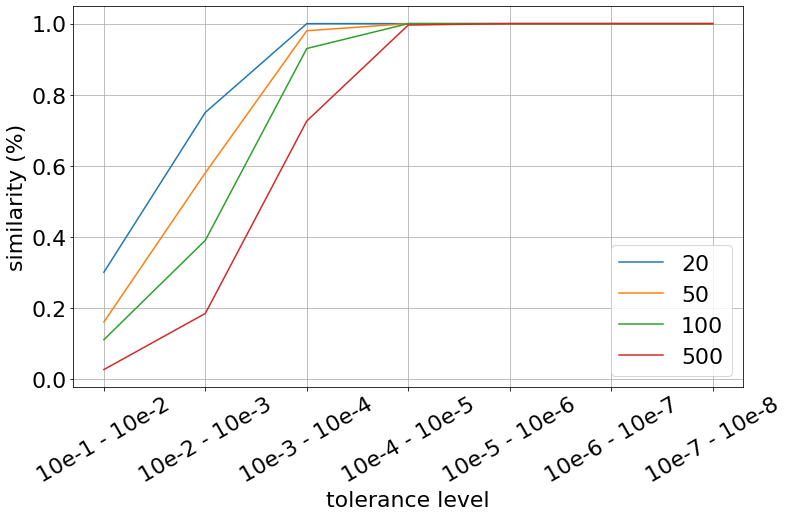

In [ ]:
# GRAPH FRAME

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_gf, y_gf_20, label = "20")
plt.xticks(x_gf)
plt.xticks(rotation=30)

plt.plot(x_gf, y_gf_50, label = "50")
plt.plot(x_gf, y_gf_100, label = "100")
plt.plot(x_gf, y_gf_500, label = "500")

plt.legend(loc=4)

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')

plt.title('GraphFrame')

plt.show()

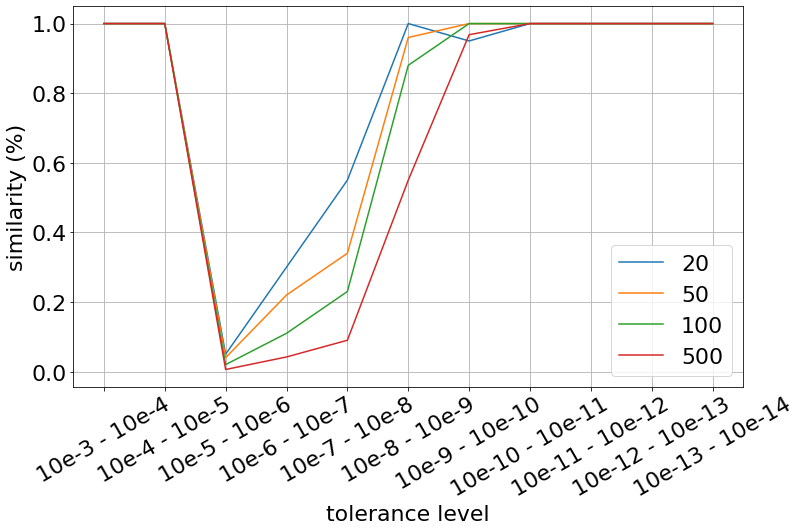

In [ ]:
# NETWORKX

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_net, y_net_20, label = "20")
plt.xticks(x_net)
plt.xticks(rotation=30)

plt.plot(x_net, y_net_50, label = "50")
plt.plot(x_net, y_net_100, label = "100")
plt.plot(x_net, y_net_500, label = "500")

plt.legend(loc=4)

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')

plt.title('NetworkX')
  
plt.show()

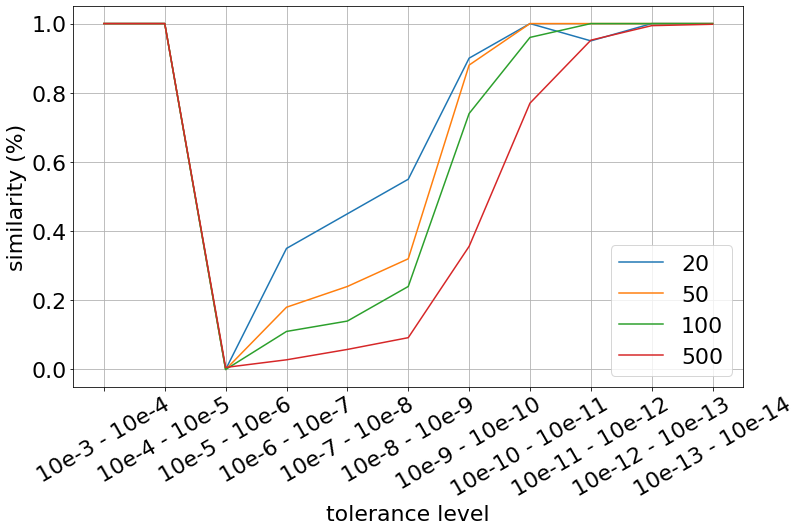

In [ ]:
# FROM SCRATCH

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_scratch, y_scratch_20, label = "20")
plt.xticks(x_scratch)
plt.xticks(rotation=30)

plt.plot(x_scratch, y_scratch_50, label = "50")
plt.plot(x_scratch, y_scratch_100, label = "100")
plt.plot(x_scratch, y_scratch_500, label = "500")

plt.legend(loc=4)

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')

plt.title('From Scratch - norm 1')

plt.show()

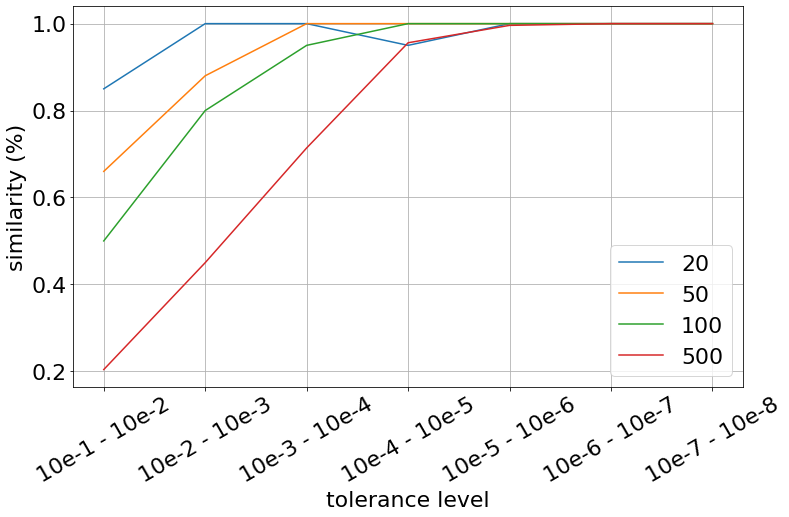

In [ ]:
# FROM SCRATCH - NORM N

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_scratch_n, y_scratch_n_20, label = "20")
plt.xticks(x_scratch_n)
plt.xticks(rotation=30)

plt.plot(x_scratch_n, y_scratch_n_50, label = "50")
plt.plot(x_scratch_n, y_scratch_n_100, label = "100")
plt.plot(x_scratch_n, y_scratch_n_500, label = "500")

plt.legend(loc=4)

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')

plt.title('From Scratch - norm N')

plt.show()

# GRAPH - iterations in stratch methods

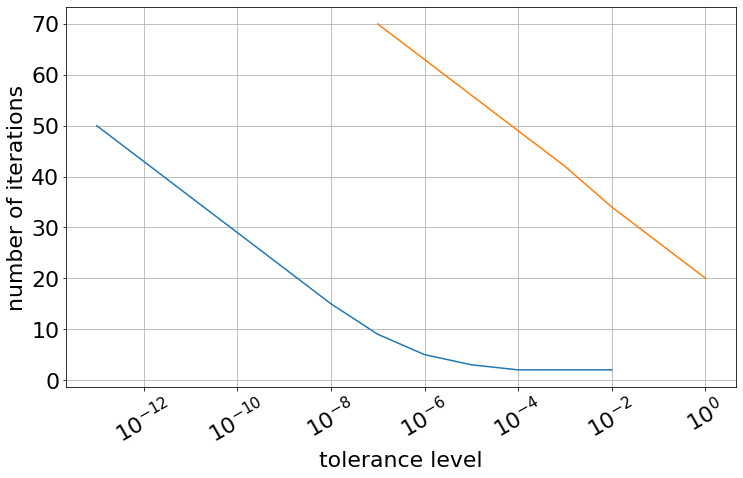

In [ ]:
# FROM SCRATCH - ITERATION

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_iterations, y_iterations, label = "norm 1")
plt.xticks(x_iterations)
plt.xscale('log')
plt.xticks(rotation=30)

plt.plot(x_iterations_n, y_iterations_n, label = "norm N")

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('number of iterations')

plt.title('From Scratch - Num of iterations')
  
plt.show()

# GRAPH - from scratch - convergency of sum

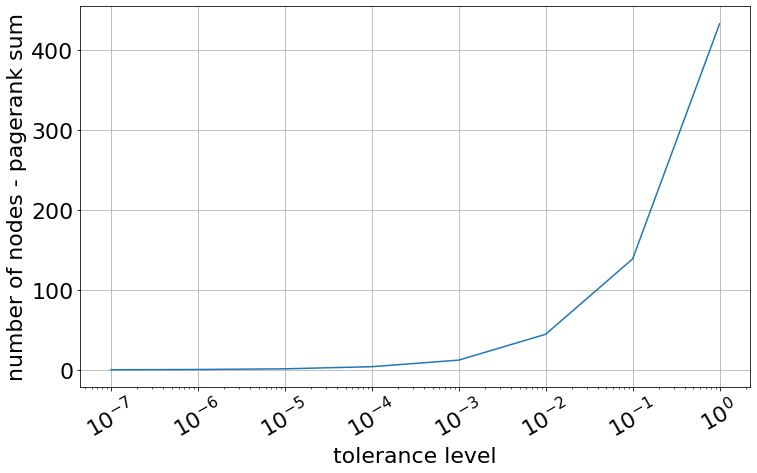

In [ ]:
# FROM SCRATCH - convergency of sum

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_difference_n, y_difference_n, label = "norm N")

plt.xscale('log')

plt.xticks(rotation=30)

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('number of nodes - pagerank sum')

plt.title('From Scratch m')
  
plt.show()

# GRAPH - precisions

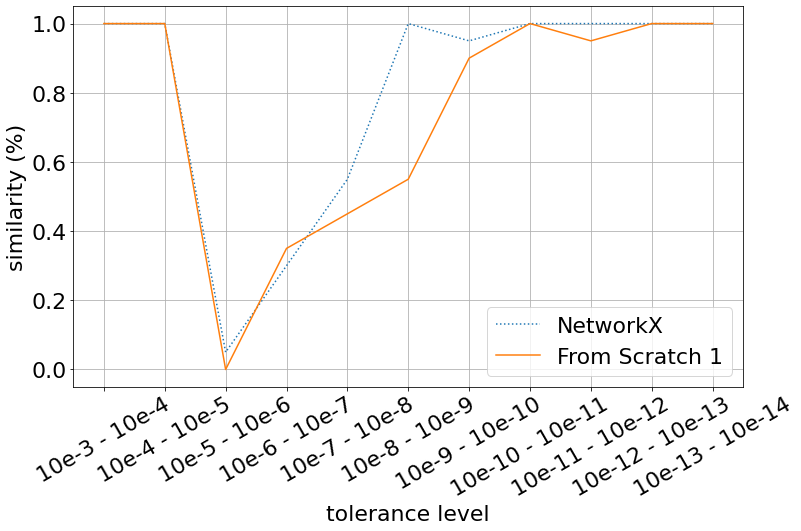

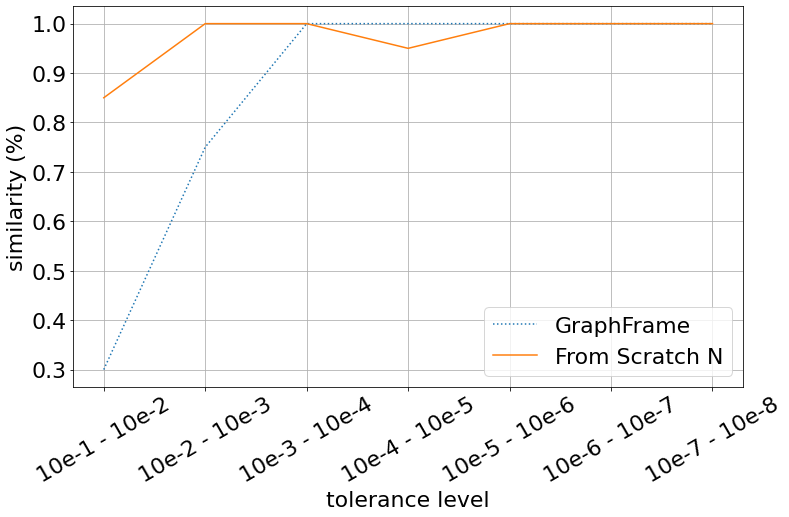

In [ ]:
# PRECISION 20

# NETWORKX - SCRATCH 1

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_net, y_net_20, ":", label = "NetworkX")
plt.xticks(x_net)
plt.xticks(rotation=30)
plt.plot(x_scratch, y_scratch_20, label = "From Scratch 1")
plt.legend(loc=4)
plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')
plt.title('Precision 20 - NetworkX vs. Scratch 1')

plt.show()



# GRATHFRAME - SCRATCH N

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_gf, y_gf_20, ":", label = "GraphFrame")
plt.xticks(x_gf)
plt.xticks(rotation=30)
plt.plot(x_scratch_n, y_scratch_n_20, label = "From Scratch N")
plt.grid()
plt.legend(loc=4)

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')

plt.title('Precision 20 - GraphFrame vs. Scratch N')
  
plt.show()

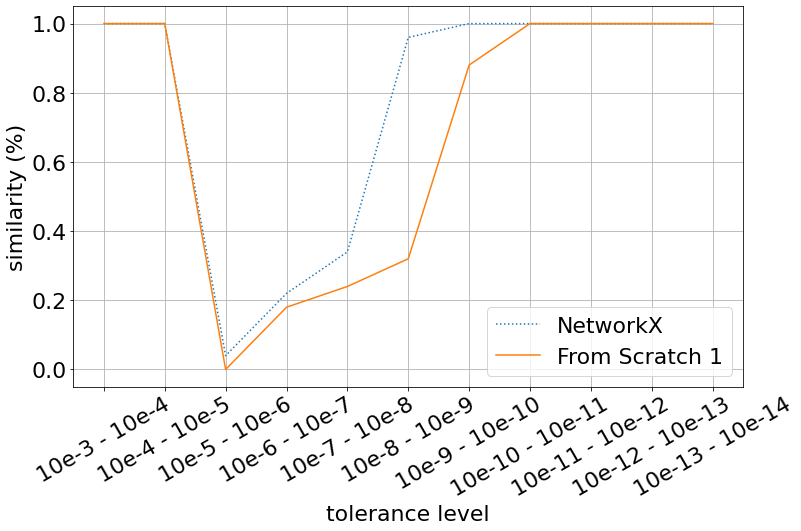

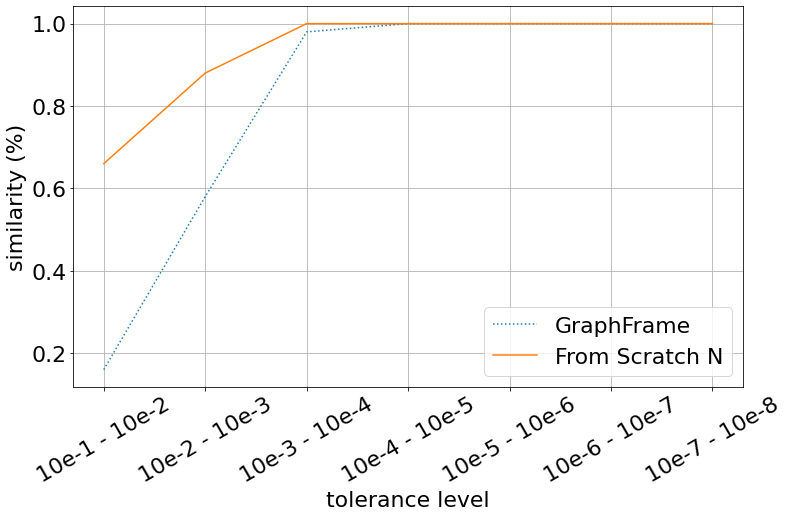

In [ ]:
# PRECISION 50

# NETWORKX - SCRATCH 1

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_net, y_net_50, ":", label = "NetworkX")
plt.xticks(x_net)
plt.xticks(rotation=30)
plt.plot(x_scratch, y_scratch_50, label = "From Scratch 1")
plt.legend(loc=4)
plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')
plt.title('Precision 50 - NetworkX vs. Scratch 1')

plt.show()



# GRATHFRAME - SCRATCH N

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_gf, y_gf_50, ":", label = "GraphFrame")
plt.xticks(x_gf)
plt.xticks(rotation=30)

plt.plot(x_scratch_n, y_scratch_n_50, label = "From Scratch N")
plt.grid()
plt.legend(loc=4)

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')

plt.title('Precision 50 - GraphFrame vs. Scratch N')
  
plt.show()

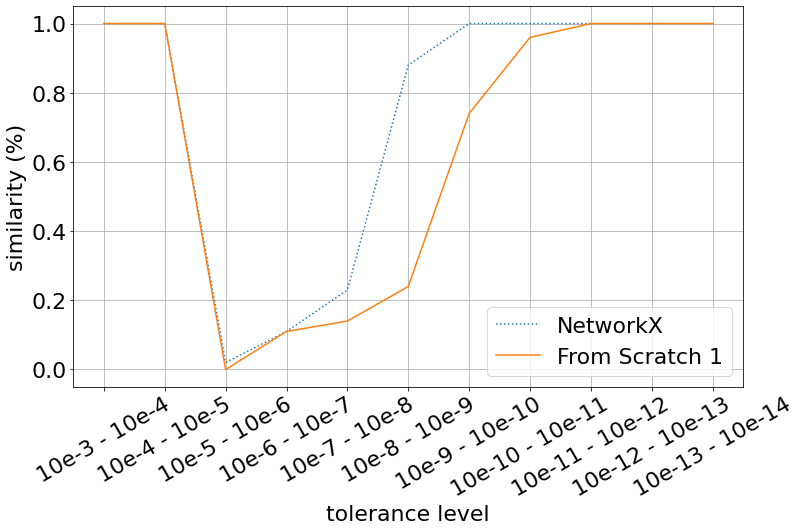

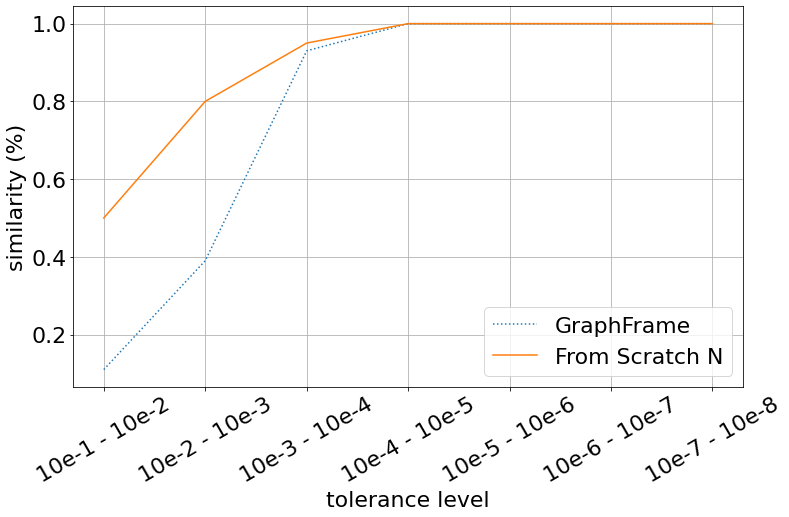

In [ ]:
# PRECISION 100

# NETWORKX - SCRATCH 1

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})
plt.plot(x_net, y_net_100, ":", label = "NetworkX")
plt.xticks(x_net)
plt.xticks(rotation=30)
plt.plot(x_scratch, y_scratch_100, label = "From Scratch 1")
plt.legend(loc=4)
plt.grid()
plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')

plt.title('Precision 100 - NetworkX vs. Scratch 1')
plt.show()



# GRATHFRAME - SCRATCH N

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})
plt.plot(x_gf, y_gf_100, ":", label = "GraphFrame")
plt.xticks(x_gf)
plt.xticks(rotation=30)

plt.plot(x_scratch_n, y_scratch_n_100, label = "From Scratch N")

plt.legend(loc=4)
plt.grid()
plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')
plt.title('Precision 100 - GraphFrame vs. Scratch N')

plt.show()

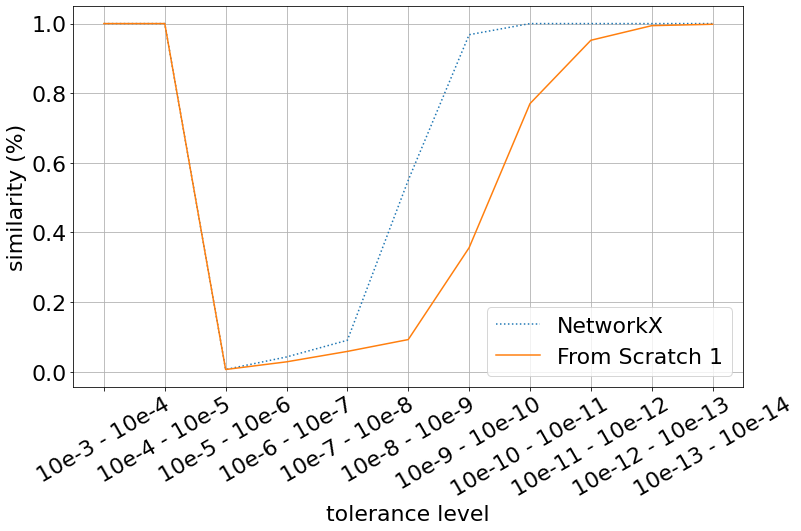

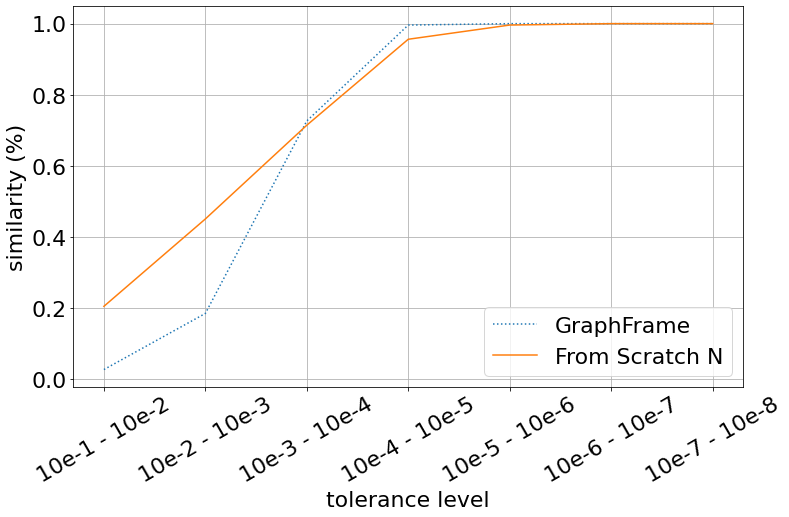

In [ ]:
# PRECISION 500

# NETWORKX - SCRATCH 1

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_net, y_net_500, ":", label = "NetworkX")
plt.xticks(x_net) 
plt.xticks(rotation=30)
plt.plot(x_scratch, y_scratch_500, label = "From Scratch 1")
plt.legend(loc=4)
plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')
plt.title('Precision 500 - NetworkX vs. Scratch 1')

plt.show()



# GRATHFRAME - SCRATCH N

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_gf, y_gf_500, ":", label = "GraphFrame")
plt.xticks(x_gf)
plt.xticks(rotation=30)

plt.plot(x_scratch_n, y_scratch_n_500, label = "From Scratch N")

plt.legend(loc=4)
plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')
plt.title('Precision 500 - GraphFrame vs. Scratch N')
  
plt.show()

# Implementation with bigger dataset

In [ ]:
title_basics.createOrReplaceTempView("title_basics")
title_principals.createOrReplaceTempView("title_principals") # queste due sono necessarie?
sql_df = spark.sql("Select t1.*, t2.* from title_principals as t1 INNER JOIN title_basics as t2 ON t1.tconst = t2.tconst where t2.titleType= 'movie' ")

dataset = sql_df.rdd.map(lambda x: ( int(x[0][2:]) , x[2], x[3], x[14]))\
                   .filter(lambda x: x[3].find("Drama") != -1 )\
                   .filter(lambda x: x[2] == "actor" or x[2] == "actress" or x[2] == "self")\
                   .map(lambda x: (x[1], x[0]))\
                   .groupByKey()\
                   .map(lambda x : (x[0], list(x[1])))

dataset = dataset.map(lambda x: [(a, b) for a in x[1] for b in x[1] if a!=b]).flatMap(lambda x: x).distinct()

In [ ]:
nodes = dataset.sortBy(lambda x: x[0]).map(lambda x: x[0]).distinct()
num_nodes = nodes.count()
num_nodes

In [ ]:
indexes = nodes.zipWithIndex().map(lambda x: ( x[0], x[1] + 1 ) )
collection_indexes = OrderedDict(indexes.collect())

dataset = dataset.map(lambda x: ( collection_indexes[x[0]], collection_indexes[x[1]] ) )

num_edges = dataset.count()
num_edges

In [ ]:
out_degree = dataset.countByKey()

M = dataset.map(lambda x:(x[0],x[1],1/out_degree[x[0]]))

In [ ]:
scratch_e3 = compute_page_rank_n(M, num_nodes, tolerance = 10e-3)
scratch_e4 = compute_page_rank_n(M, num_nodes, tolerance = 10e-4)
scratch_e5 = compute_page_rank_n(M, num_nodes, tolerance = 10e-5)
scratch_e6 = compute_page_rank_n(M, num_nodes, tolerance = 10e-6)
scratch_e7 = compute_page_rank_n(M, num_nodes, tolerance = 10e-7)
scratch_e8 = compute_page_rank_n(M, num_nodes, tolerance = 10e-8)
scratch_e9 = compute_page_rank_n(M, num_nodes, tolerance = 10e-9)
scratch_e10 = compute_page_rank_n(M, num_nodes, tolerance = 10e-10)
scratch_e11 = compute_page_rank_n(M, num_nodes, tolerance = 10e-11)
scratch_e12 = compute_page_rank_n(M, num_nodes, tolerance = 10e-12)
scratch_e13 = compute_page_rank_n(M, num_nodes, tolerance = 10e-13)
scratch_e14 = compute_page_rank_n(M, num_nodes, tolerance = 10e-14)

In [ ]:
x_iterations = [10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 10e-9, 10e-10, 10e-11, 10e-12, 10e-13, 10e-14]
y_iterations = [scratch_e3[1], scratch_e4[1], scratch_e5[1], scratch_e6[1], scratch_e7[1], scratch_e8[1], scratch_e9[1], scratch_e10[1],scratch_e11[1], scratch_e12[1], scratch_e13[1], scratch_e14[1]]

In [ ]:
scratch_e3 = dict(sorted(scratch_e3[0].items(), key=lambda item: item[1], reverse=True))
scratch_e4 = dict(sorted(scratch_e4[0].items(), key=lambda item: item[1], reverse=True))
scratch_e5 = dict(sorted(scratch_e5[0].items(), key=lambda item: item[1], reverse=True))
scratch_e6 = dict(sorted(scratch_e6[0].items(), key=lambda item: item[1], reverse=True))
scratch_e7 = dict(sorted(scratch_e7[0].items(), key=lambda item: item[1], reverse=True))
scratch_e8 = dict(sorted(scratch_e8[0].items(), key=lambda item: item[1], reverse=True))
scratch_e9 = dict(sorted(scratch_e9[0].items(), key=lambda item: item[1], reverse=True))
scratch_e10 = dict(sorted(scratch_e10[0].items(), key=lambda item: item[1], reverse=True))
scratch_e11 = dict(sorted(scratch_e11[0].items(), key=lambda item: item[1], reverse=True))
scratch_e12 = dict(sorted(scratch_e12[0].items(), key=lambda item: item[1], reverse=True))
scratch_e13 = dict(sorted(scratch_e13[0].items(), key=lambda item: item[1], reverse=True))
scratch_e14 = dict(sorted(scratch_e14[0].items(), key=lambda item: item[1], reverse=True))

In [ ]:
appo_3 = sum(list(scratch_e3.values()))
appo_4 = sum(list(scratch_e4.values()))
appo_5 = sum(list(scratch_e5.values()))
appo_6 = sum(list(scratch_e6.values()))
appo_7 = sum(list(scratch_e7.values()))
appo_8 = sum(list(scratch_e8.values()))
appo_9 = sum(list(scratch_e9.values()))
appo_10 = sum(list(scratch_e10.values()))
appo_11 = sum(list(scratch_e11.values()))
appo_12 = sum(list(scratch_e12.values()))
appo_13 = sum(list(scratch_e13.values()))
appo_14 = sum(list(scratch_e14.values()))

x_difference = [10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 10e-9, 10e-10, 10e-11, 10e-12, 10e-13, 10e-14]
y_difference = [1 - appo_3, 1 - appo_4, 1 - appo_5, 1 - appo_6, 1 - appo_7, 1 - appo_8, 1 - appo_9, 1 - appo_10,  1 - appo_11, 1 - appo_12,  1 - appo_13, 1 - appo_14]

1 - appo_3, 1 - appo_4, 1 - appo_5, 1 - appo_6, 1 - appo_7, 1 - appo_8, 1 - appo_9, 1 - appo_10,  1 - appo_11, 1 - appo_12,  1 - appo_13, 1 - appo_14

In [ ]:
sc_e3_20 = list(scratch_e3.keys())[:20]
sc_e4_20 = list(scratch_e4.keys())[:20]
sc_e5_20 = list(scratch_e5.keys())[:20]
sc_e6_20 = list(scratch_e6.keys())[:20]
sc_e7_20 = list(scratch_e7.keys())[:20]
sc_e8_20 = list(scratch_e8.keys())[:20]
sc_e9_20 = list(scratch_e9.keys())[:20]
sc_e10_20 = list(scratch_e10.keys())[:20]
sc_e11_20 = list(scratch_e11.keys())[:20]
sc_e12_20 = list(scratch_e12.keys())[:20]
sc_e13_20 = list(scratch_e13.keys())[:20]
sc_e14_20 = list(scratch_e14.keys())[:20]

compute_similarity(sc_e3_20, sc_e4_20, 2), compute_similarity(sc_e4_20, sc_e5_20, 2), compute_similarity(sc_e5_20, sc_e6_20, 2), compute_similarity(sc_e6_20, sc_e7_20, 2), compute_similarity(sc_e7_20, sc_e8_20, 2), compute_similarity(sc_e8_20, sc_e9_20, 2), compute_similarity(sc_e9_20, sc_e10_20, 2), compute_similarity(sc_e10_20, sc_e11_20, 2), compute_similarity(sc_e11_20, sc_e12_20, 2), compute_similarity(sc_e12_20, sc_e13_20, 2), compute_similarity(sc_e13_20, sc_e14_20, 2)

In [ ]:
x_scratch = ["10e-3 - 10e-4", "10e-4 - 10e-5", "10e-5 - 10e-6", "10e-6 - 10e-7", "10e-7 - 10e-8", "10e-8 - 10e-9", "10e-9 - 10e-10", "10e-10 - 10e-11", "10e-11 - 10e-12", "10e-12 - 10e-13", "10e-13 - 10e-14"]
y_scratch_20 = [compute_similarity(sc_e3_20, sc_e4_20, 2)[0], compute_similarity(sc_e4_20, sc_e5_20, 2)[0], compute_similarity(sc_e5_20, sc_e6_20, 2)[0], compute_similarity(sc_e6_20, sc_e7_20, 2)[0], compute_similarity(sc_e7_20, sc_e8_20, 2)[0], compute_similarity(sc_e8_20, sc_e9_20, 2)[0], compute_similarity(sc_e9_20, sc_e10_20, 2)[0], compute_similarity(sc_e10_20, sc_e11_20, 2)[0], compute_similarity(sc_e11_20, sc_e12_20, 2)[0], compute_similarity(sc_e12_20, sc_e13_20, 2)[0], compute_similarity(sc_e13_20, sc_e14_20, 2)[0]]

In [ ]:
sc_e3_50 = list(scratch_e3.keys())[:50]
sc_e4_50 = list(scratch_e4.keys())[:50]
sc_e5_50 = list(scratch_e5.keys())[:50]
sc_e6_50 = list(scratch_e6.keys())[:50]
sc_e7_50 = list(scratch_e7.keys())[:50]
sc_e8_50 = list(scratch_e8.keys())[:50]
sc_e9_50 = list(scratch_e9.keys())[:50]
sc_e10_50 = list(scratch_e10.keys())[:50]
sc_e11_50 = list(scratch_e11.keys())[:50]
sc_e12_50 = list(scratch_e12.keys())[:50]
sc_e13_50 = list(scratch_e13.keys())[:50]
sc_e14_50 = list(scratch_e14.keys())[:50]

compute_similarity(sc_e3_50, sc_e4_50, 2), compute_similarity(sc_e4_50, sc_e5_50, 2), compute_similarity(sc_e5_50, sc_e6_50, 2), compute_similarity(sc_e6_50, sc_e7_50, 2), compute_similarity(sc_e7_50, sc_e8_50, 2), compute_similarity(sc_e8_50, sc_e9_50, 2), compute_similarity(sc_e9_50, sc_e10_50, 2), compute_similarity(sc_e10_50, sc_e11_50, 2), compute_similarity(sc_e11_50, sc_e12_50, 2), compute_similarity(sc_e12_50, sc_e13_50, 2), compute_similarity(sc_e13_50, sc_e14_50, 2)

In [ ]:
y_scratch_50 = [compute_similarity(sc_e3_50, sc_e4_50, 2)[0], compute_similarity(sc_e4_50, sc_e5_50, 2)[0], compute_similarity(sc_e5_50, sc_e6_50, 2)[0], compute_similarity(sc_e6_50, sc_e7_50, 2)[0], compute_similarity(sc_e7_50, sc_e8_50, 2)[0], compute_similarity(sc_e8_50, sc_e9_50, 2)[0], compute_similarity(sc_e9_50, sc_e10_50, 2)[0], compute_similarity(sc_e10_50, sc_e11_50, 2)[0], compute_similarity(sc_e11_50, sc_e12_50, 2)[0], compute_similarity(sc_e12_50, sc_e13_50, 2)[0], compute_similarity(sc_e13_50, sc_e14_50, 2)[0]]

In [ ]:
sc_e3_100 = list(scratch_e3.keys())[:100]
sc_e4_100 = list(scratch_e4.keys())[:100]
sc_e5_100 = list(scratch_e5.keys())[:100]
sc_e6_100 = list(scratch_e6.keys())[:100]
sc_e7_100 = list(scratch_e7.keys())[:100]
sc_e8_100 = list(scratch_e8.keys())[:100]
sc_e9_100 = list(scratch_e9.keys())[:100]
sc_e10_100 = list(scratch_e10.keys())[:100]
sc_e11_100 = list(scratch_e11.keys())[:100]
sc_e12_100 = list(scratch_e12.keys())[:100]
sc_e13_100 = list(scratch_e13.keys())[:100]
sc_e14_100 = list(scratch_e14.keys())[:100]

compute_similarity(sc_e3_100, sc_e4_100, 2), compute_similarity(sc_e4_100, sc_e5_100, 2), compute_similarity(sc_e5_100, sc_e6_100, 2), compute_similarity(sc_e6_100, sc_e7_100, 2), compute_similarity(sc_e7_100, sc_e8_100, 2), compute_similarity(sc_e8_100, sc_e9_100, 2), compute_similarity(sc_e9_100, sc_e10_100, 2), compute_similarity(sc_e10_100, sc_e11_100, 2), compute_similarity(sc_e11_100, sc_e12_100, 2), compute_similarity(sc_e12_100, sc_e13_100, 2), compute_similarity(sc_e13_100, sc_e14_100, 2)

In [ ]:
y_scratch_100 = [compute_similarity(sc_e3_100, sc_e4_100, 2)[0], compute_similarity(sc_e4_100, sc_e5_100, 2)[0], compute_similarity(sc_e5_100, sc_e6_100, 2)[0], compute_similarity(sc_e6_100, sc_e7_100, 2)[0], compute_similarity(sc_e7_100, sc_e8_100, 2)[0], compute_similarity(sc_e8_100, sc_e9_100, 2)[0], compute_similarity(sc_e9_100, sc_e10_100, 2)[0], compute_similarity(sc_e10_100, sc_e11_100, 2)[0], compute_similarity(sc_e11_100, sc_e12_100, 2)[0], compute_similarity(sc_e12_100, sc_e13_100, 2)[0], compute_similarity(sc_e13_100, sc_e14_100, 2)[0]]

In [ ]:
sc_e3_500 = list(scratch_e3.keys())[:500]
sc_e4_500 = list(scratch_e4.keys())[:500]
sc_e5_500 = list(scratch_e5.keys())[:500]
sc_e6_500 = list(scratch_e6.keys())[:500]
sc_e7_500 = list(scratch_e7.keys())[:500]
sc_e8_500 = list(scratch_e8.keys())[:500]
sc_e9_500 = list(scratch_e9.keys())[:500]
sc_e10_500 = list(scratch_e10.keys())[:500]
sc_e11_500 = list(scratch_e11.keys())[:500]
sc_e12_500 = list(scratch_e12.keys())[:500]
sc_e13_500 = list(scratch_e13.keys())[:500]
sc_e14_500 = list(scratch_e14.keys())[:500]

compute_similarity(sc_e3_500, sc_e4_500, 2), compute_similarity(sc_e4_500, sc_e5_500, 2), compute_similarity(sc_e5_500, sc_e6_500, 2), compute_similarity(sc_e6_500, sc_e7_500, 2), compute_similarity(sc_e7_500, sc_e8_500, 2), compute_similarity(sc_e8_500, sc_e9_500, 2), compute_similarity(sc_e9_500, sc_e10_500, 2), compute_similarity(sc_e10_500, sc_e11_500, 2), compute_similarity(sc_e11_500, sc_e12_500, 2), compute_similarity(sc_e12_500, sc_e13_500, 2), compute_similarity(sc_e13_500, sc_e14_500, 2)

In [ ]:
y_scratch_500 = [compute_similarity(sc_e3_500, sc_e4_500, 2)[0], compute_similarity(sc_e4_500, sc_e5_500, 2)[0], compute_similarity(sc_e5_500, sc_e6_500, 2)[0], compute_similarity(sc_e6_500, sc_e7_500, 2)[0], compute_similarity(sc_e7_500, sc_e8_500, 2)[0], compute_similarity(sc_e8_500, sc_e9_500, 2)[0], compute_similarity(sc_e9_500, sc_e10_500, 2)[0], compute_similarity(sc_e10_500, sc_e11_500, 2)[0], compute_similarity(sc_e11_500, sc_e12_500, 2)[0], compute_similarity(sc_e12_500, sc_e13_500, 2)[0], compute_similarity(sc_e13_500, sc_e14_500, 2)[0]]

In [ ]:
list(scratch_e14.items())[:20]

In [ ]:
# FROM SCRATCH

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_scratch, y_scratch_20, label = "20")
plt.xticks(x_scratch)
plt.xticks(rotation=30)

plt.plot(x_scratch, y_scratch_50, label = "50")
plt.plot(x_scratch, y_scratch_100, label = "100")
plt.plot(x_scratch, y_scratch_500, label = "500")

plt.legend(loc=4)

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('similarity (%)')
plt.title('From Scratch - norm 1')

plt.show()

In [ ]:
# FROM SCRATCH - ITERATION

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 22})

plt.plot(x_iterations, y_iterations, label = "norm 1")
plt.xticks(x_iterations)
plt.xscale('log')
plt.xticks(rotation=30)

plt.grid()

plt.xlabel('tolerance level')
plt.ylabel('number of iterations')
plt.title('From Scratch - Num of iterations')
  
plt.show()